In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import Linear

## Defining the function and solution

In [121]:
c = 2
x0 = 0.5
def u_(x, t):
    _x = x - c * t
    func = 0.5/torch.cosh(0.5*c**(0.5)*(_x-x0))**2
    return func

In [122]:
def eval_net(net, u_, x, t):
    u = u_(x,t).detach().reshape(-1,1)
    u_hat = net(x,t).detach().reshape(-1,1)
    MSE = torch.mean((u - u_hat)**2)
    return MSE

In [194]:
n_x = 100
n_i = 50
n_b = 50

# Domain
x = torch.rand(n_x,1, requires_grad=True)
t = torch.rand(x.shape, requires_grad=True)
u = u_(x, t)

# Initial
x_i = torch.rand(n_i,1,requires_grad=True)
t_i = torch.zeros(x_i.shape, requires_grad=True)
u_i = u_(x_i, t_i)

# Boundary
x_b = torch.cat((torch.zeros(n_b,1, requires_grad=True),torch.ones(n_b,1, requires_grad=True)))
t_b = torch.rand(x_b.shape, requires_grad=True)
u_b = u_(x_b, t_b)

Text(0.5, 1.0, 'Training points in domain')

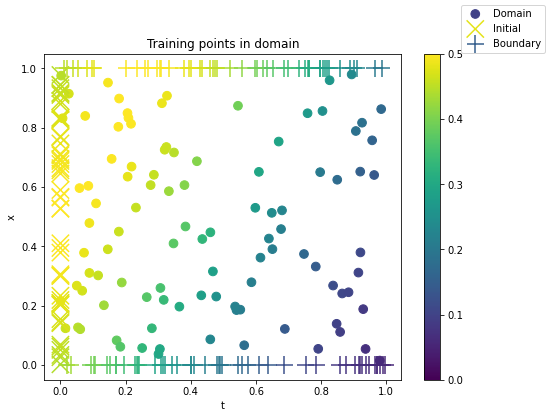

In [195]:
fig, ax = plt.subplots(figsize=(8,6))
d = ax.scatter(t.detach(), x.detach(), c=u.detach(), marker='.', s=300, label='Domain', vmax=0.5, vmin=0)
i = ax.scatter(t_i.detach(), x_i.detach(), c=u_i.detach(), marker='x', s=300, label='Initial', vmax=0.5, vmin=0)
b = ax.scatter(t_b.detach(), x_b.detach(), c=u_b.detach(), marker='+', s=300, label='Boundary', vmax=0.5, vmin=0)
fig.colorbar(d)
fig.legend()
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title('Training points in domain')

In [196]:
class Net(nn.Module):
    def __init__(self,
        N_in, N_out, N_hid,
        loss_func=nn.MSELoss(),
        LEARNING_RATE = 0.001,
        optimizer = optim.Adam
                ):
        
        super(Net, self).__init__()
        self.layers = nn.Sequential(
                nn.Linear(in_features=N_in,
                          out_features=N_hid,
                          bias=True),
                nn.Sigmoid(),
                nn.Linear(in_features=N_hid,
                          out_features=N_out,
                          bias=True)
        )
        
        self.loss_func = loss_func
        self.optimizer = optimizer(self.parameters(), lr=LEARNING_RATE)
        
    def forward(self, x, t):
        x = torch.cat((x, t), dim=1)
        out = self.layers(x)
        return out
    
    def loss_BC(self, x_b, t_b, u_b):
        u_b_hat = self.forward(x_b, t_b)
        loss = self.loss_func(u_b, u_b_hat.reshape(u_b.shape))
        return loss
    
    def loss_IC(self, x_i, t_i, u_i):
        u_i_hat = self.forward(x_i, t_i)
        loss = self.loss_func(u_i, u_i_hat.reshape(u_i.shape))
        return loss

    def loss_PDE(self, x, t):
        u_hat = self.forward(x, t)
        u_x_hat = torch.autograd.grad(u_hat, x, torch.ones(x.shape), create_graph=True)[0]
        u_xx_hat = torch.autograd.grad(u_x_hat, x, torch.ones(x.shape), create_graph=True)[0]
        u_xxx_hat = torch.autograd.grad(u_xx_hat, x, torch.ones(x.shape), create_graph=True)[0]
        u_t_hat = torch.autograd.grad(u_hat, t, torch.ones(t.shape), create_graph=True)[0]
        
        loss = self.loss_func(-6*u_hat*u_x_hat - u_xxx_hat, u_t_hat.reshape(u_x_hat.shape))
        return loss
    
    def loss(self, x, t, x_b, t_b, u_b, x_i, t_i, u_i):
        loss = self.loss_PDE(x, t) + self.loss_BC(x_b, t_b, u_b) + self.loss_IC(x_i, t_i, u_i)
        return loss
    
    def step(self, x, t, x_b, t_b, u_b, x_i, t_i, u_i):
        self.train()
        self.optimizer.zero_grad()
        loss = self.loss(x, t, x_b, t_b, u_b, x_i, t_i, u_i)
        loss.backward(retain_graph=True)
        self.optimizer.step()
        self.eval()
        return self.loss_PDE(x, t), self.loss_BC(x_b, t_b, u_b), self.loss_IC(x_i, t_i, u_i)

In [197]:
loss = []
loss_data = []
loss_epochs = []
epochs = 20000
xi, ti = torch.meshgrid(torch.linspace(0,1,101, requires_grad=True), torch.linspace(0,1,101, requires_grad=True))
xi, ti = xi.reshape(-1, 1), ti.reshape(-1, 1)
net = Net(N_in=2, N_out=1, N_hid=100)
for e in range(epochs):
    loss.append(net.step(x, t, x_b, t_b, u_b, x_i, t_i, u_i))
    loss_data.append(eval_net(net, u_, xi, ti))
    if e%1000 == 0:
        print('Epoch: {:d}. Data loss: {:.2f}'.format(e, loss_data[-1]))
        


Epoch: 0. Data loss: 0.14
Epoch: 1000. Data loss: 0.00
Epoch: 2000. Data loss: 0.00
Epoch: 3000. Data loss: 0.00
Epoch: 4000. Data loss: 0.00
Epoch: 5000. Data loss: 0.00
Epoch: 6000. Data loss: 0.00
Epoch: 7000. Data loss: 0.00
Epoch: 8000. Data loss: 0.00
Epoch: 9000. Data loss: 0.00
Epoch: 10000. Data loss: 0.00
Epoch: 11000. Data loss: 0.00
Epoch: 12000. Data loss: 0.00
Epoch: 13000. Data loss: 0.00
Epoch: 14000. Data loss: 0.00
Epoch: 15000. Data loss: 0.00
Epoch: 16000. Data loss: 0.00
Epoch: 17000. Data loss: 0.00
Epoch: 18000. Data loss: 0.00
Epoch: 19000. Data loss: 0.00


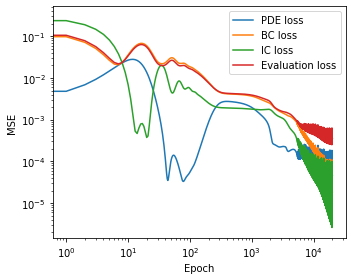

In [228]:
fig, ax = plt.subplots(figsize=(5,4))
ax.semilogy([pde.detach() for pde, bc, ic in loss], label='PDE loss')
ax.semilogy([bc.detach() for pde, bc, ic in loss], label='BC loss')
ax.semilogy([ic.detach() for pde, bc, ic in loss], label='IC loss')
ax.loglog(loss_data, label='Evaluation loss')
ax.legend()
ax.set_ylabel('MSE')
ax.set_xlabel('Epoch')
fig.tight_layout()
fig.savefig('./figs/IVP_PDE_NL_loss.png', dpi=600)

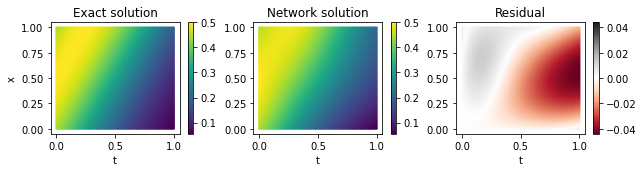

In [224]:
## Evaluate network
fig, axs = plt.subplots(1,3,figsize=(9,2.5))
xi, ti = torch.meshgrid(torch.linspace(0,1,101, requires_grad=True), torch.linspace(0,1,101, requires_grad=True))
xi, ti = xi.reshape(-1, 1), ti.reshape(-1, 1)
#x_grid = torch.hstack((xi.reshape(-1, 1), yi.reshape(-1, 1)))
minmax = u_(xi, ti).detach()
vmin = minmax.min()
vmax = minmax.max()
u = u_(xi, ti).detach()
u_hat = net(xi, ti).detach()
m = axs[0].scatter(ti.detach(), xi.detach(), s=1, c=u, vmin=vmin, vmax=vmax)
fig.colorbar(m, ax=axs[0])
axs[0].set_title('Exact solution')
axs[0].set_xlabel('t')
axs[0].set_ylabel('x')
m = axs[1].scatter(ti.detach(), xi.detach(), s=1, c=u_hat, vmin=vmin, vmax=vmax)
fig.colorbar(m, ax=axs[1])
axs[1].set_title('Network solution')
axs[1].set_xlabel('t')
m = axs[2].scatter(ti.detach(), xi.detach(), s=1, c=u-u_hat, vmin=-max(abs(u-u_hat)), vmax=max(abs(u-u_hat)), cmap='RdGy')
fig.colorbar(m, ax=axs[2])
axs[2].set_title('Residual')
axs[2].set_xlabel('t')
fig.tight_layout()
fig.savefig('./figs/IVP_PDE_NL_eval_2D.png', dpi=600)


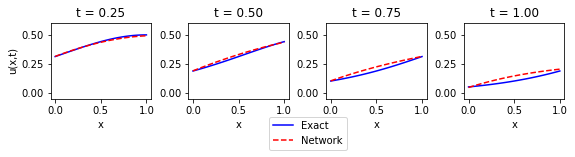

In [226]:
xi, ti = torch.meshgrid(torch.linspace(0,1,101, requires_grad=True), torch.tensor([0.25, 0.5, 0.75, 1]))
#xi, ti = xi.reshape(4, -1), ti.reshape(4, -1)
fig, axs = plt.subplots(1,4,figsize=(8,2))
for k, ax in enumerate(axs):
    x = xi[:, k].reshape(-1,1)
    t = ti[:, k].reshape(-1,1)
    u = u_(x, t).detach()
    u_hat = net(x, t).detach()
    ax.plot(x.detach(), u, color='blue', ls='-')
    ax.plot(x.detach(), u_hat, color='red', ls='--')
    ax.set_xlabel('x')
    ax.set_title('t = {:.2f}'.format(t[0].item()))
    ax.set_ylim([vmin-0.1, vmax+0.1])
axs[0].set_ylabel('u(x,t)')
fig.legend(['Exact', 'Network'], loc="lower center", bbox_to_anchor=(0.53, -0.1))
fig.tight_layout()
fig.savefig('./figs/IVP_PDE_NL_eval_1D.png', dpi=600, bbox_inches = "tight")